In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Define key phrases to check for
KEY_PHRASES = ["As a", "I want", "so that"]

def compute_metrics(input_file, reference_file=None, output_file="metrics_results.csv"):
    # Load the data
    df = pd.read_csv(input_file)

    if 'response' not in df.columns:
        print("Error: 'response' column not found in the input file.")
        return

    # If reference file is provided, load it
    references = None
    if reference_file:
        ref_df = pd.read_csv(reference_file)
        if 'reference_story' not in ref_df.columns:
            print("Error: 'reference_story' column not found in the reference file.")
            return
        references = ref_df['reference_story'][:len(df)]  # Match length of responses

    # Initialize metrics
    metrics = []

    for index, row in df.iterrows():
        response = row['response']

        # Calculate response length
        response_length = len(response.split()) if response else 0

        # Check for key phrase presence
        key_phrase_count = sum(1 for phrase in KEY_PHRASES if phrase in response)

        # Compute similarity to reference (if available)
        similarity_score = None
        if references is not None:
            vectorizer = TfidfVectorizer()
            tfidf_matrix = vectorizer.fit_transform([response, references.iloc[index]])
            similarity_score = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]

        # Append the metrics
        metrics.append({
            "model": row.get("model", "Unknown"),
            "prompt": row.get("prompt", "Unknown"),
            "review_index": row.get("review_index", "Unknown"),
            "response_length": response_length,
            "key_phrase_count": key_phrase_count,
            "similarity_score": similarity_score
        })

    # Create a DataFrame from metrics
    metrics_df = pd.DataFrame(metrics)

    # Save the metrics to a CSV file
    metrics_df.to_csv(output_file, index=False)
    print(f"Metrics results saved to {output_file}")

# Input parameters
input_file = "prompt_evaluation_results.csv"  # The file with model-generated responses
reference_file = None  # Optional: Add a reference file path if available
output_file = "metrics_results.csv"

# Run the metrics computation
compute_metrics(input_file, reference_file, output_file)


Metrics results saved to metrics_results.csv


Reordered file saved to reordered_results.csv
Metrics results saved to metrics_results.csv


C:\Users\shadm\AppData\Local\Temp\ipykernel_24920\357562508.py:82: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  WEIGHTS['similarity_score'] * metrics_df['similarity_score'].fillna(0)
C:\Users\shadm\AppData\Local\Temp\ipykernel_24920\357562508.py:95: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=metrics_df, x='model', y='response_length', hue='prompt', ci=None)


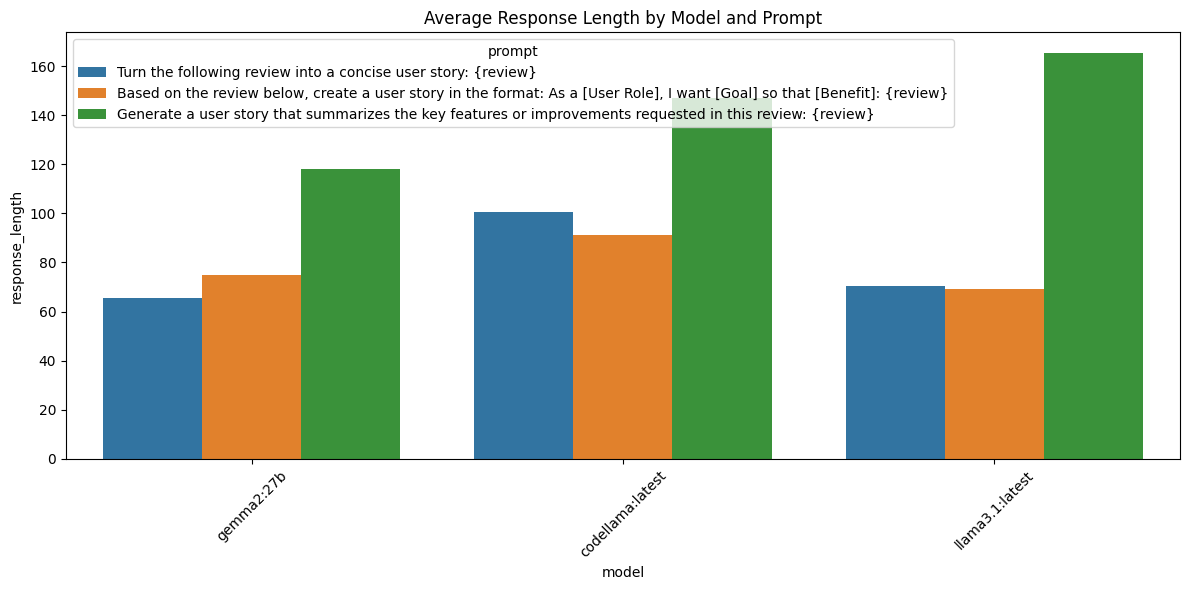

C:\Users\shadm\AppData\Local\Temp\ipykernel_24920\357562508.py:103: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=metrics_df, x='model', y='score', hue='prompt', ci=None)


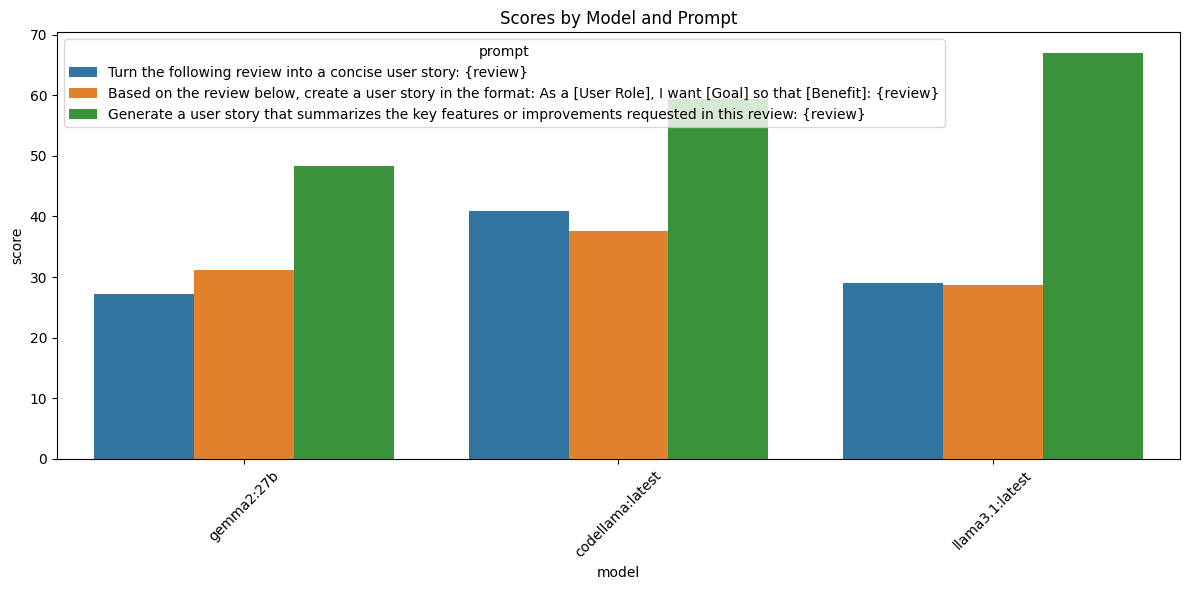

C:\Users\shadm\AppData\Local\Temp\ipykernel_24920\357562508.py:119: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


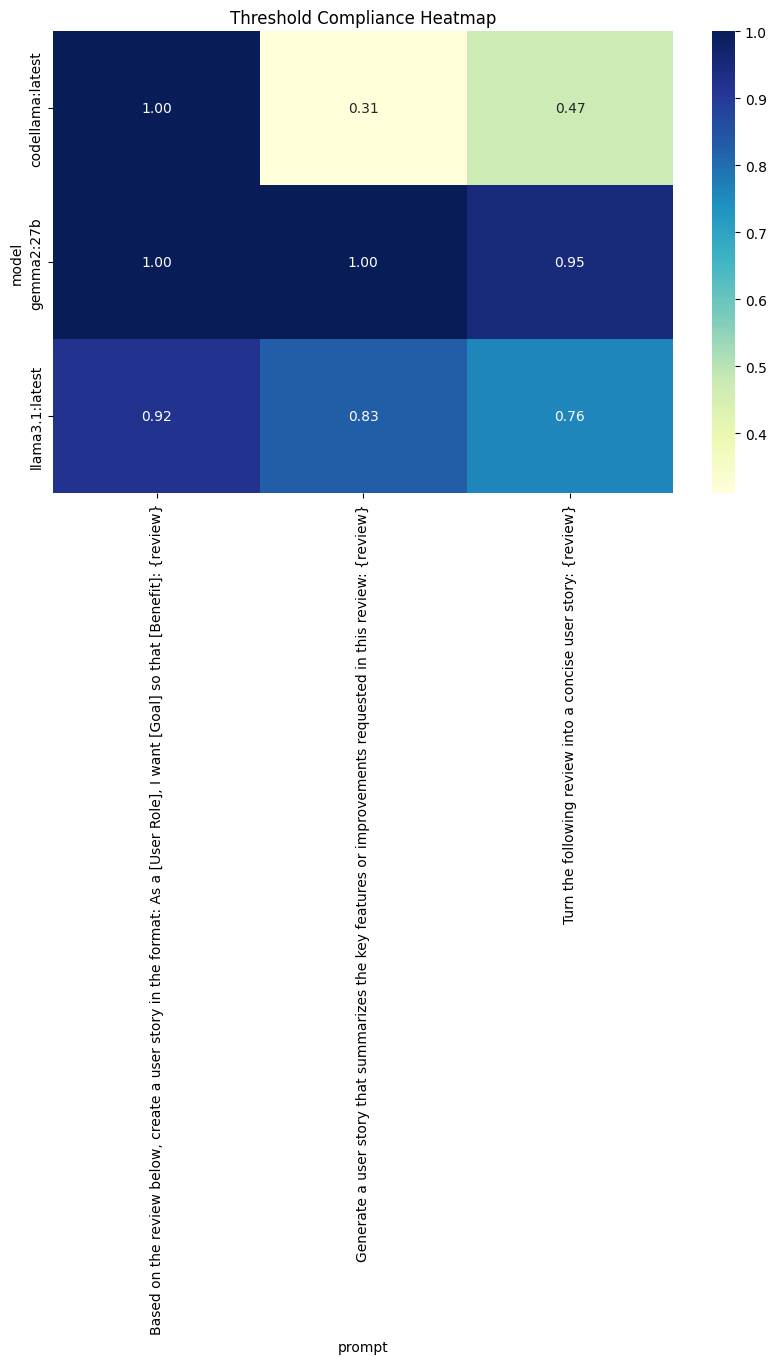

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Define key phrases to check for
KEY_PHRASES = ["As a", "I want", "so that"]

# Define thresholds for filtering
THRESHOLDS = {
    "response_length": 10,  # Minimum response length (in words)
    "key_phrase_count": 2,  # Minimum number of key phrases present
}

# Weights for scoring
WEIGHTS = {
    "response_length": 0.4,
    "key_phrase_count": 0.4,
    "similarity_score": 0.2,
}

def compute_metrics(input_file, reference_file=None, output_file="metrics_results.csv"):
    # Load the data
    df = pd.read_csv(input_file)

    if 'response' not in df.columns:
        print("Error: 'response' column not found in the input file.")
        return

    # If reference file is provided, load it
    references = None
    if reference_file:
        ref_df = pd.read_csv(reference_file)
        if 'reference_story' not in ref_df.columns:
            print("Error: 'reference_story' column not found in the reference file.")
            return
        references = ref_df['reference_story'][:len(df)]  # Match length of responses

    # Initialize metrics
    metrics = []

    for index, row in df.iterrows():
        response = row['response']

        # Calculate response length
        response_length = len(response.split()) if response else 0

        # Check for key phrase presence
        key_phrase_count = sum(1 for phrase in KEY_PHRASES if phrase in response)

        # Compute similarity to reference (if available)
        similarity_score = None
        if references is not None:
            vectorizer = TfidfVectorizer()
            tfidf_matrix = vectorizer.fit_transform([response, references.iloc[index]])
            similarity_score = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]

        # Append the metrics
        metrics.append({
            "model": row.get("model", "Unknown"),
            "prompt": row.get("prompt", "Unknown"),
            "review_index": row.get("review_index", "Unknown"),
            "response_length": response_length,
            "key_phrase_count": key_phrase_count,
            "similarity_score": similarity_score
        })

    # Create a DataFrame from metrics
    metrics_df = pd.DataFrame(metrics)

    # Filter combinations based on thresholds
    metrics_df['meets_threshold'] = (
        (metrics_df['response_length'] >= THRESHOLDS['response_length']) &
        (metrics_df['key_phrase_count'] >= THRESHOLDS['key_phrase_count'])
    )

    # Calculate weighted scores for ranking
    metrics_df['score'] = (
        WEIGHTS['response_length'] * metrics_df['response_length'] +
        WEIGHTS['key_phrase_count'] * metrics_df['key_phrase_count'] +
        WEIGHTS['similarity_score'] * metrics_df['similarity_score'].fillna(0)
    )

    # Save the metrics to a CSV file
    metrics_df.to_csv(output_file, index=False)
    print(f"Metrics results saved to {output_file}")

    # Generate visualizations
    visualize_metrics(metrics_df)

def visualize_metrics(metrics_df):
    # Plot average response length by model and prompt
    plt.figure(figsize=(12, 6))
    sns.barplot(data=metrics_df, x='model', y='response_length', hue='prompt', ci=None)
    plt.title('Average Response Length by Model and Prompt')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot scores by model and prompt
    plt.figure(figsize=(12, 6))
    sns.barplot(data=metrics_df, x='model', y='score', hue='prompt', ci=None)
    plt.title('Scores by Model and Prompt')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Heatmap for threshold compliance
    threshold_pivot = metrics_df.pivot_table(
        values='meets_threshold', 
        index='model', 
        columns='prompt', 
        aggfunc='mean'
    )
    plt.figure(figsize=(10, 6))
    sns.heatmap(threshold_pivot, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title('Threshold Compliance Heatmap')
    plt.tight_layout()
    plt.show()

def reorder_columns(input_file, output_file):
    # Load the data
    df = pd.read_csv(input_file)

    # Define the desired mapping between prompt types and responses
    prompt_mapping = {
        "Turn the following review into a concise user story: {review}": "response_prompt_1",
        "Based on the review below, create a user story in the format: As a [User Role], I want [Goal] so that [Benefit]: {review}": "response_prompt_2",
        "Generate a user story that summarizes the key features or improvements requested in this review: {review}": "response_prompt_3"
    }

    # Rename columns for clarity if needed
    for original_prompt, new_name in prompt_mapping.items():
        df.rename(columns={original_prompt: new_name}, inplace=True, errors='ignore')

    # Updated column order
    column_order = [
        "response_prompt_1",
        "response_prompt_2",
        "response_prompt_3",
        "model",
        "response",
        "response_length",
        "key_phrase_count",
        "similarity_score",
        "score",
        "meets_threshold"
    ]

    # Check for missing columns
    missing_columns = [col for col in column_order if col not in df.columns]
    if missing_columns:
        print(f"Warning: Missing columns {missing_columns} in input file. Proceeding with available columns.")

    # Reorder columns based on availability
    reordered_df = df[[col for col in column_order if col in df.columns]]

    # Save the reordered DataFrame
    reordered_df.to_csv(output_file, index=False)
    print(f"Reordered file saved to {output_file}")

# Call the function
reorder_columns(metrics_output_file, reordered_output_file)


# Input parameters
input_file = "prompt_evaluation_results.csv"  # The file with model-generated responses
reference_file = None  # Optional: Add a reference file path if available
metrics_output_file = "metrics_results.csv"
reordered_output_file = "reordered_results.csv"

# Run the metrics computation
compute_metrics(input_file, reference_file, metrics_output_file)

# Reorder columns in the CSV



In [5]:
#print the column and row names 
df = pd.read_csv("prompt_evaluation_results.csv")
print(df.columns)
print(df.index)


Index(['model', 'prompt', 'review_index', 'review_content', 'response'], dtype='object')
RangeIndex(start=0, stop=900, step=1)
